# ViT

We will implement the ViT architecture introduced in [An Image is Worth 16x16 Words](https://paperswithcode.com/paper/an-image-is-worth-16x16-words-transformers-1).

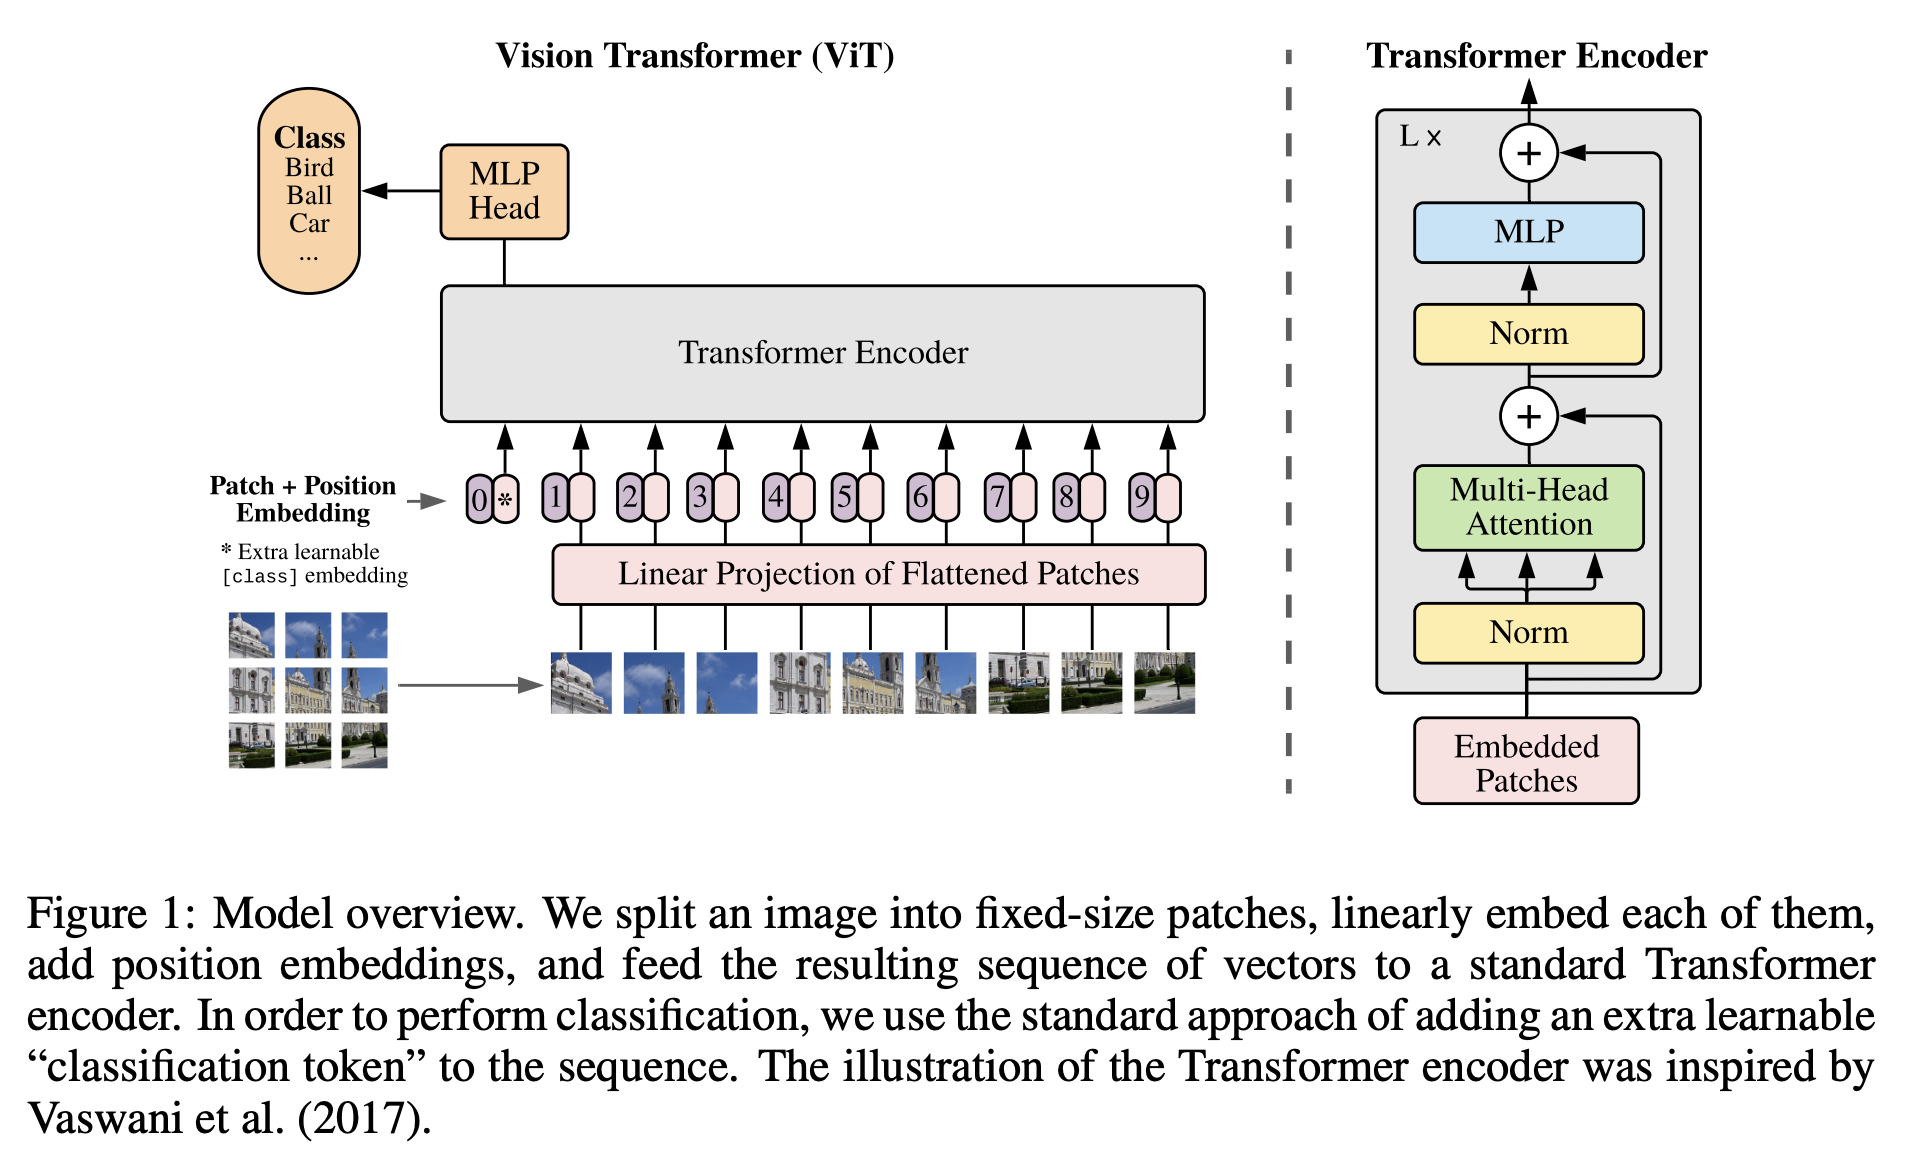

We'll follow the [PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/#6-equation-3-multilayer-perceptron-mlp) tutorial by [@mrdbourke](https://github.com/mrdbourke/pytorch-deep-learning)


Requirements for execution on cloud:
- [] Update EPOCS at [Training Hyperparameters](#31-hyperparameters)
- [] Update *num_encoders* parameter to [ViT](#31-hyperparameters) class constructor.

# 1. Import Modules

## 1.1. Configure toolbox

In [51]:
# ! git clone https://github.com/NareshPS/doi-ml-toolbox.git
# ! mv doi-ml-toolbox/torch/toolbox .
# ! rm -rf doi-ml-toolbox

import os
import sys

sys.path.append(os.getcwd() + '/..')

## 1.2. Import Modules

In [52]:
import random
import torch
import torchvision
import torchinfo

from toolbox import data_download, data_setup, engine, utils, evaluation, visualization
from torchinfo import summary as model_summary
from torchvision import transforms
from torch import nn
from matplotlib import pyplot as plt
from timeit import default_timer as timer 
from pathlib import Path
from PIL import Image

print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')
print(f'torchinfo version: {torchinfo.__version__}')

torch version: 2.1.0.dev20230608
torchvision version: 0.16.0.dev20230608
torchinfo version: 1.8.0


# 2. Hyperparameters and Image Transform

## 2.1. Hyperparameters

In [53]:
EPOCHS = 2
BATCH_SIZE = 32
SEED = 3

IMG_SIZE = 224
PATCH_SIZE = 16
NUM_CLASSES = 3

NUM_ENCODERS = 1

## 2.2. Prepare Image Transform

In [54]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Image Transform: {transform}')

Image Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


# 3. Model Design
- Input: An image input as a list of 16x16 patches.
- Output: Probabilities of the input belonging to each of the prossible classes.

A ViT model has the following components:
1. Patch + Position Embedding
2. Linear Projection of Flattened Patches
3. Layer Normalization
4. Multi-Headed Attention
5. Multilayer Perceptron
6. Transformer Encoder
7. Classification Head



## 3.1. Patching + Patch Embedding

This converts an image into patches. We'll be using 16x16 patches.

### 3.1.1. Patch Visualization

In [55]:
image = Image.open('12301.jpg')
transforms.PILToTensor()(image)

tensor([[[  3,   2,   1,  ...,   8,   8,   7],
         [  3,   3,   2,  ...,   4,   3,   2],
         [  2,   2,   3,  ...,   4,   3,   3],
         ...,
         [ 24,  29,  31,  ..., 124, 113, 115],
         [ 27,  32,  32,  ..., 119, 110, 126],
         [ 32,  36,  34,  ..., 119, 113, 143]],

        [[  3,   2,   1,  ...,   9,   9,   8],
         [  3,   3,   2,  ...,   5,   4,   3],
         [  4,   4,   5,  ...,   5,   4,   4],
         ...,
         [  7,  12,  13,  ...,  59,  48,  50],
         [  8,  13,  14,  ...,  55,  45,  61],
         [ 13,  17,  16,  ...,  55,  48,  78]],

        [[  1,   0,   0,  ...,  11,  11,  10],
         [  1,   1,   0,  ...,   7,   6,   5],
         [  3,   3,   4,  ...,   7,   6,   6],
         ...,
         [  0,   5,   9,  ...,  27,  20,  22],
         [  4,   9,  10,  ...,  20,  13,  31],
         [  9,  13,  12,  ...,  19,  16,  46]]], dtype=torch.uint8)

Image Shape: torch.Size([3, 224, 224])
Label: 0
Permuted Shape: torch.Size([224, 224, 3])
Number of patches per row: 14    
Number of patches per column: 14    
Total patches: 196    
Patch size: 16 pixels x 16 pixels


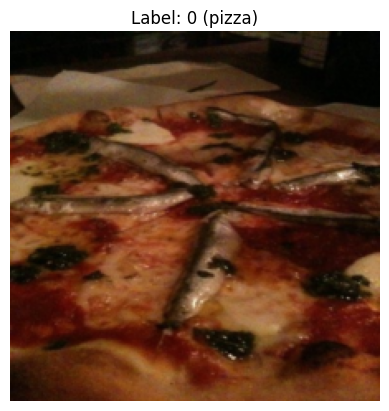

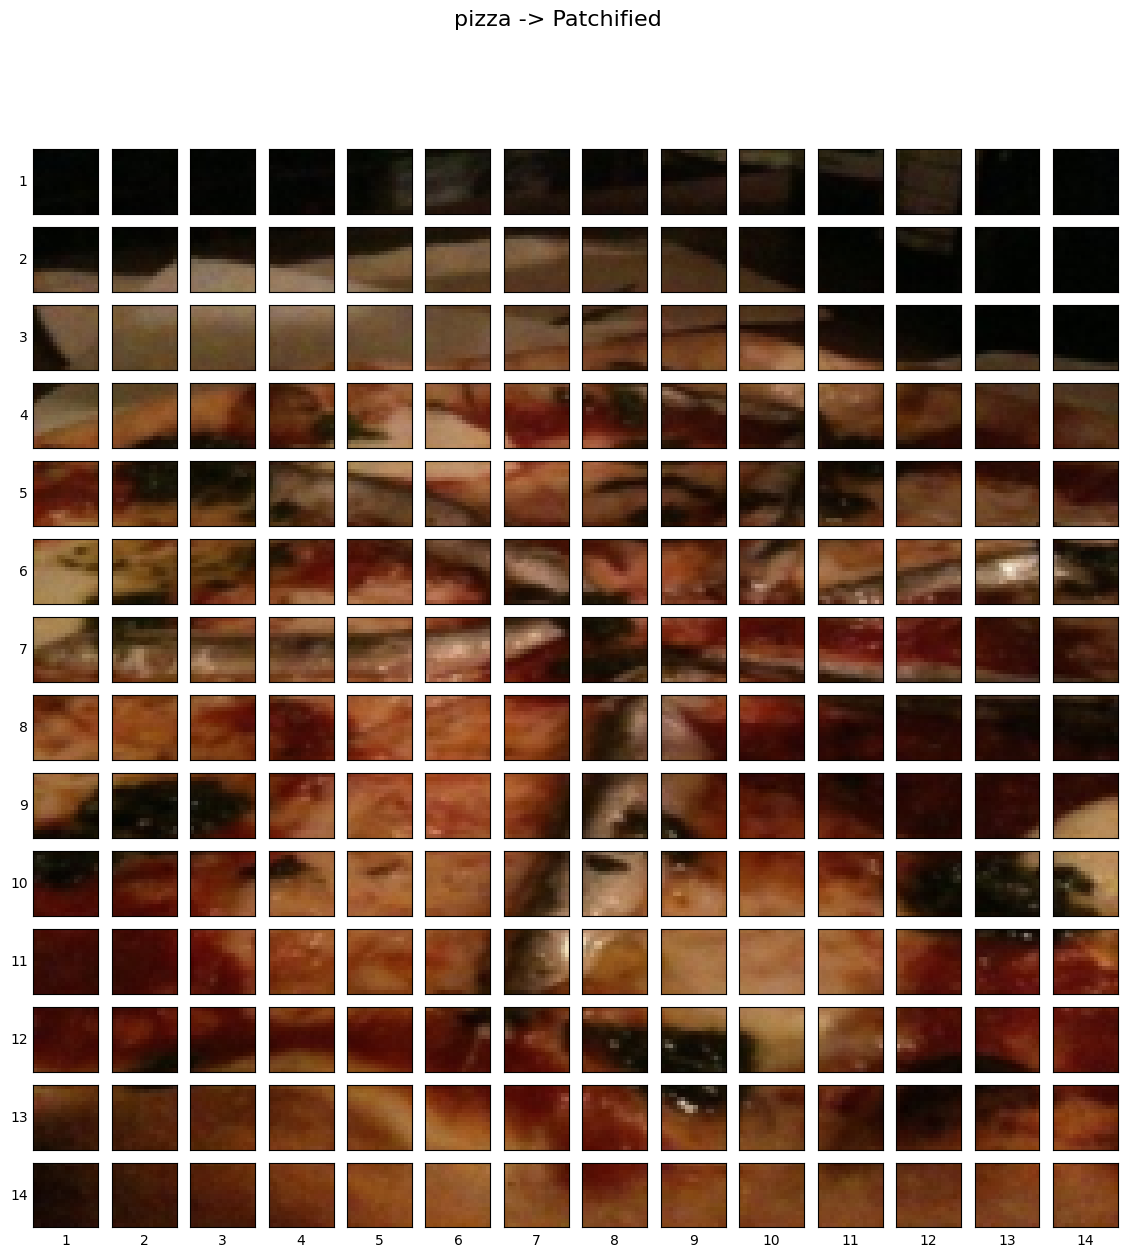

In [56]:
# 1. Get a single input
image, label = transform(Image.open('12301.jpg')), 0
class_names = ['pizza', 'sushi']

# 2. View input shapes
print(f'Image Shape: {image.shape}')
print(f'Label: {label}')

# 3. Visualize input image
image_permute = image.permute(1, 2, 0)
print(f'Permuted Shape: {image_permute.shape}')

plt.imshow(image_permute)
plt.title(f'Label: {label} ({class_names[label]})')
plt.axis(False)

# 4. Transform input image into patches
num_patches = IMG_SIZE // PATCH_SIZE 
assert IMG_SIZE % PATCH_SIZE == 0, "Image size must be divisible by patch size" 

print(f"Number of patches per row: {num_patches}\
    \nNumber of patches per column: {num_patches}\
    \nTotal patches: {num_patches*num_patches}\
    \nPatch size: {PATCH_SIZE} pixels x {PATCH_SIZE} pixels"
)

# 5. Create subplots to show the patches
fig, axes = plt.subplots(
    nrows=num_patches,
    ncols=num_patches, 
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True
)

# 6. Loop through height and width of image
for row_id, row_start in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
    for col_id, col_start in enumerate(range(0, IMG_SIZE, PATCH_SIZE)):
        ax = axes[row_id, col_id]

        # 6.1. Add patch to the figure
        ax.imshow(image_permute[row_start:row_start+PATCH_SIZE, col_start:col_start+PATCH_SIZE, :])

        # 6.2. Configure patch appearance and descriptive info
        ax.set_ylabel(row_id + 1, rotation='horizontal', verticalalignment='center', horizontalalignment='right')
        ax.set_xlabel(col_id + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.label_outer()

# 7. Show patches
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

### 3.1.2. Patching + Embedding Using a Conv Layer

Embedding Shape: torch.Size([1, 768, 14, 14])
Show embeddings for feature indices: [727, 666, 256, 460, 590]


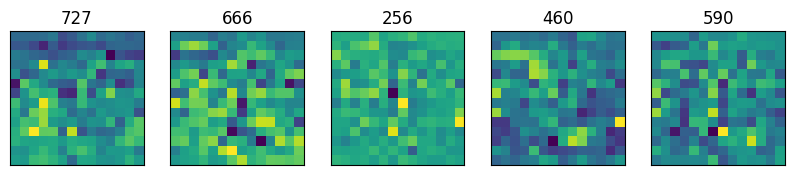

In [57]:
# 1. Create a conv layer to generate patch embeddings.
out_channels = (PATCH_SIZE**2)*3
embedding_layer = nn.Conv2d(
    in_channels=3,
    out_channels=out_channels,
    kernel_size=PATCH_SIZE,
    stride=PATCH_SIZE,
    padding=0
)

# 2. Generate embeddings
image_embedding = embedding_layer(image.unsqueeze(0))
print(f'Embedding Shape: {image_embedding.shape}')

# 3. Create a plot to show a few random embeddings
num_rows, num_cols = 1, 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols*2, 3))
random_embedding_indices = random.sample(range(out_channels), k=5)
print(f"Show embeddings for feature indices: {random_embedding_indices}")

# 4. Plot random embeddings
for i, idx in enumerate(random_embedding_indices):
    image_conv_feature_map = image_embedding[:, idx, :, :]
    axes[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axes[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axes[i].set_title(f'{idx}')

### 3.1.3. Flatten the patches

In [58]:
# 1. Create a flatten layer
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)

# 2. Show Results
flattened_image = flatten_layer(image_embedding)

print(f"Conv Output Shape: {image_embedding.shape} -> [batch, embedding_dim, height, width]")
print(f"Flattened Shape: {flattened_image.shape} -> [batch, embedding_dim, patch_size*patch_size]")

Conv Output Shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, height, width]
Flattened Shape: torch.Size([1, 768, 196]) -> [batch, embedding_dim, patch_size*patch_size]


### 3.1.4. Permute embedding tensor as [BATCH, NUM_PATCHES, EMBEDDINGS_DIMS]

In [59]:
embedding_permute = flattened_image.permute(0, 2, 1)
print(f"Flattened Shape: {flattened_image.shape} -> [batch, embedding_dim, patch_size*patch_size]")
print(f"Permuted Flattened Shape: {embedding_permute.shape} -> [batch, patch_size*patch_size, embedding_dim]")

Flattened Shape: torch.Size([1, 768, 196]) -> [batch, embedding_dim, patch_size*patch_size]
Permuted Flattened Shape: torch.Size([1, 196, 768]) -> [batch, patch_size*patch_size, embedding_dim]


### 3.1.5. Compose a PyTorch patching module

In [60]:
# 1. Subclass nn.Module
class PatchEmbedding(nn.Module):
    """It converts an 2D image input into a sequence of learnable embeddings.
    Example Usage:
        l = PatchEmbedding(in_channels=3, embedding_dim=768, patch_size=16)
    """
    def __init__(self, in_channels: int, embedding_dim: int, patch_size: int):
        super().__init__()
        self.patch_size = patch_size

        # 2. Initialize a convolution layer to create patch embeddings
        self.embedding_layer = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        # 3. Initialize a flatten layer to flatten 2D patches to 1D.
        self.flatten_layer = nn.Flatten(start_dim=-2, end_dim=-1)
    
    # 4. Define the forward pass
    def forward(self, x):
        # Validate input
        assert x.shape[-1] % self.patch_size == 0, f'Input image shape: {x.shape[-2:]} must be divisible by patch_size: {patch_size}'
        x = self.embedding_layer(x)
        x = self.flatten_layer(x)
        x = x.permute(0, 2, 1)

        return x

l = PatchEmbedding(in_channels=3, embedding_dim=PATCH_SIZE*PATCH_SIZE*3, patch_size=PATCH_SIZE)
patch_embedding = l(image.unsqueeze(0))
print(f'Image Shape: {image.shape}')
print(f'PatchEmbedding Output Shape: {patch_embedding.shape}')

model_summary(l,
    input_size=image.unsqueeze(0).shape,
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=['var_names']
)

Image Shape: torch.Size([3, 224, 224])
PatchEmbedding Output Shape: torch.Size([1, 196, 768])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (embedding_layer)               [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten_layer)                [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## 3.2. Class Token Embedding

In [61]:
# 1. Create a random patch embedding.
patch_embedding = torch.randn(2, 196, 768)

# 2. Create a learnable class embedding
batch_size, embedding_dims = patch_embedding.shape[0], patch_embedding.shape[-1]
learnable_class_embedding = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dims)
)

# 3. Show sample class embedding
print(f'Class Embedding Shape: {learnable_class_embedding.shape} -> [BATCH, 1, EMBEDDING_DIMS]')

# 4. Attach class embedding to the patch embedding
patch_with_class_embedding = torch.cat((learnable_class_embedding, patch_embedding), dim=1)
print(f'Patch+Class Embedding Shape: {patch_with_class_embedding.shape} -> [BATCH, 1, EMBEDDING_DIMS]')

# 5. Show a sample of combined embedding
print(f'Patch+Class Embedding: {patch_with_class_embedding[0, :3, :10]}')

Class Embedding Shape: torch.Size([2, 1, 768]) -> [BATCH, 1, EMBEDDING_DIMS]
Patch+Class Embedding Shape: torch.Size([2, 197, 768]) -> [BATCH, 1, EMBEDDING_DIMS]
Patch+Class Embedding: tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000],
        [ 0.2765, -0.9131, -0.8207, -0.0793,  0.7193,  0.9378,  1.0414, -0.4779,
         -1.3157, -0.0342],
        [ 1.1345,  0.2635,  0.6167,  0.0976,  1.0286, -0.6087, -1.4436, -0.2970,
         -0.3654,  0.2404]], grad_fn=<SliceBackward0>)


## 3.3. Position Embedding

In [62]:
# 1. Calculate the number of patches
num_patches, embedding_dims = (IMG_SIZE // PATCH_SIZE)**2, patch_with_class_embedding.shape[-1]
print(f'Number of Patches: {num_patches}\
    \nEmbedding Dims: {embedding_dims}')

# 2. Create learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, num_patches + 1, embedding_dims))
print(f'First 10 embeddings: {position_embedding[:, :10, :10]}\
    \nPosition Embedding Shape: {position_embedding.shape}')

# 3. Combine Patch + Class Embedding and Position Embedding
patch_and_position_embedding = patch_with_class_embedding + position_embedding
print(f'First 10 patch_and_position_embedding: {patch_and_position_embedding[:, :10, :10]}\
    \nEmbedding Shape: {patch_and_position_embedding.shape}')

Number of Patches: 196    
Embedding Dims: 768
First 10 embeddings: tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)    
Position Embedding Shape: torch.Size([1, 197, 768])
First 10 patch_and_position_embedding: tensor([[[ 2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,
           2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00,  2.0000e+00],
         [ 1.2765e+00,  8.6889e-02,  1.7933e-01,  9.2069e-01,  1.7193e+00,
           1.9378e+00,  2.0414e+00,  5.2214e-01, -3.1575e-01,  9.6575e-01

## 3.4. Image to Embedding

In [63]:
# 1. Set seeds for predictability
utils.set_seeds(SEED)

# 2. Print image tensor
print(f'Image: {image[:, :5, :5]}\
    \nImage Shape: {image.shape}')

# 3. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(
    in_channels=3,
    embedding_dim=PATCH_SIZE*PATCH_SIZE*3,
    patch_size=PATCH_SIZE
)

# 4. Compute patch embedding
patch_embedding = patch_embedding_layer(image.unsqueeze(0))
print(f'Patch Embedding: {patch_embedding[:, :5, :5]}\
    \nShape: {patch_embedding.shape}')

# 5. Create class token
batch_size = patch_embedding.shape[0]
embedding_dims = patch_embedding.shape[-1]
class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dims)
)

# 6. Attach class token to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch Embedding With Class Token: {patch_embedding_class_token[:, :5, :5]}\
    \nShape: {patch_embedding_class_token.shape}')

# 7. Create position embedding
num_patches = (IMG_SIZE // PATCH_SIZE)**2
position_embedding = nn.Parameter(
    torch.ones(1, num_patches + 1, embedding_dims)
)

# 8. Attach position embedding
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch+Class+Position Embedding: {patch_and_position_embedding[:, :5, :5]}\
    \nShape: {patch_and_position_embedding.shape}')

Image: tensor([[[0.0118, 0.0078, 0.0078, 0.0196, 0.0235],
         [0.0078, 0.0078, 0.0078, 0.0118, 0.0118],
         [0.0000, 0.0000, 0.0039, 0.0078, 0.0078],
         [0.0000, 0.0039, 0.0078, 0.0039, 0.0078],
         [0.0000, 0.0039, 0.0039, 0.0039, 0.0039]],

        [[0.0118, 0.0078, 0.0118, 0.0196, 0.0275],
         [0.0157, 0.0157, 0.0196, 0.0196, 0.0196],
         [0.0157, 0.0157, 0.0157, 0.0235, 0.0235],
         [0.0157, 0.0196, 0.0235, 0.0157, 0.0196],
         [0.0157, 0.0196, 0.0196, 0.0196, 0.0157]],

        [[0.0039, 0.0039, 0.0039, 0.0157, 0.0196],
         [0.0118, 0.0118, 0.0118, 0.0157, 0.0157],
         [0.0157, 0.0118, 0.0157, 0.0196, 0.0196],
         [0.0196, 0.0235, 0.0275, 0.0196, 0.0235],
         [0.0157, 0.0157, 0.0196, 0.0196, 0.0157]]])    
Image Shape: torch.Size([3, 224, 224])
Patch Embedding: tensor([[[-0.0124, -0.0123, -0.0117, -0.0361, -0.0414],
         [-0.0161, -0.0207, -0.0206, -0.0312, -0.0475],
         [-0.0098, -0.0152, -0.0233, -0.0378, -0.0

## 3.5. Multi Head Self-Attention (MSA)

It applies a layer norm followed by a multi headed self-attention layer over the input.

Input -> [LayerNorm -> MultiheadAttention] = Output

### 3.5.1. Define MultiHeadSelfAttentionBlock

In [64]:
# 1. Create a class for MSA block
class MultiHeadSelfAttentionBlock(nn.Module):
    # 2. Initialize the module with hyperparameters
    def __init__(self,
        embedding_dim: int = 768,
        num_heads: int = 12,
        dropout: float = 0.
    ):
        super().__init__()

        # 3. Initialize the normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the MSA layer
        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
    
    # 5. Create forward pass
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attention(query=x, key=x, value=x, need_weights=False)

        return attn_output

### 3.5.2. Create MSA Block

In [65]:
# 1. Hyperparameters
embedding_dim, num_heads = 768, 12

# 2. Create MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(
    embedding_dim=embedding_dim,
    num_heads=num_heads
)

# 3. Send patch and position embeddings through MSA block
msa_output = multihead_self_attention_block(patch_and_position_embedding)
print(f'MSA Input Shape: {patch_and_position_embedding.shape}')
print(f'MSA Output: {msa_output[:, :5, :5]}\
    \nShape: {msa_output.shape}')

MSA Input Shape: torch.Size([1, 197, 768])
MSA Output: tensor([[[-0.2184,  0.5484,  0.7617,  0.4309,  0.7085],
         [-0.2269,  0.5644,  0.7659,  0.3971,  0.7161],
         [-0.2262,  0.5653,  0.7626,  0.3958,  0.7167],
         [-0.2251,  0.5626,  0.7651,  0.4000,  0.7134],
         [-0.2319,  0.5684,  0.7662,  0.3998,  0.7178]]],
       grad_fn=<SliceBackward0>)    
Shape: torch.Size([1, 197, 768])


## 3.6. Multilayer Perceptron (MLP)

[LayerNorm -> Linear -> Non-Linearity -> Dropout -> Linear -> Dropout]

### 3.6.1. Define MLPBlock

In [66]:
# 1. Create a MLPBlock class that implements nn.Module
class MLPBlock(nn.Module):
    """Creates a Multilayer Perceptron Block for ViT

    It is structured as:
    [LayerNorm -> Linear -> Non-Linearity -> Dropout -> Linear -> Dropout]
    """
    # 2. Initialize the object with input hyperparameters
    def __init__(self, embedding_dim: int, mlp_dim: int, dropout: float=0.1):
        super().__init__()

        # 3. Create a Layer Norm
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create a Multilayer Perceptron (MLP) block
        self.mlp_block = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_dim),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_dim, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    
    # 5. Implement the forward pass
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp_block(x)

        return x

### 3.6.2. Create MLP Block

In [67]:
# 1. Hyperparameters
embedding_dim, mlp_dim, dropout = 768, 768*4, .1

# 2. Create MLP block
mlp_block = MLPBlock(
    embedding_dim=embedding_dim,
    mlp_dim=mlp_dim,
    dropout=dropout
)

# 3. Send patch and position embeddings through MLP block
mlp_output = mlp_block(msa_output)
print(f'MSA Input Shape: {msa_output.shape}')
print(f'MLP Output: {mlp_output[:, :5, :5]}\
    \nShape: {mlp_output.shape}')

MSA Input Shape: torch.Size([1, 197, 768])
MLP Output: tensor([[[-0.0000,  0.0614, -0.0259,  0.0613,  0.0178],
         [-0.0978,  0.0202, -0.0000, -0.0118, -0.1240],
         [-0.1440, -0.1279, -0.0581, -0.0078,  0.0463],
         [-0.2193, -0.0816,  0.0134,  0.0248, -0.1500],
         [-0.2487, -0.0000,  0.0244,  0.0499,  0.0170]]],
       grad_fn=<SliceBackward0>)    
Shape: torch.Size([1, 197, 768])


## 3.7. Transformer Encoder

Transformer Encoder is composed of MSA and MLP blocks. A couple of skip connects are added to short-circuit information from lower layers. The structure of encoder is as follows:

[MSABlock -> [MSABlock_output + MSABlock_input] -> MLPBlock -> [MLPBlock_output + MLPBlock_input]]

### 3.7.1. Define TransformerEncoderBlock

In [68]:
# 1. Create a TransformerEncoderBlock class that implements nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a transformer encoder block which assembles MSA and MLP blocks together.

    [MSABlock -> [MSABlock_output + MSABlock_input] -> MLPBlock -> [MLPBlock_output + MLPBlock_input]]
    """

    # 2. Initialize the class with the hyperparameters
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        num_heads: int = 12,
        attn_dropout: float = 0.,
        mlp_dropout: float = 0.1,
    ):
        super().__init__()

        # 3. Create a MSA block
        self.msa_block = MultiHeadSelfAttentionBlock(
            embedding_dim=embedding_dim, num_heads=num_heads, dropout=attn_dropout
        )

        # 4. Create MLP block
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim, mlp_dim=mlp_dim, dropout=mlp_dropout
        )

    # 5. Implement the forward pass
    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x

        return x

# 1. Hyperparameters
embedding_dim, mlp_dim, num_heads, mlp_dropout = 768, 768*4, 12, .1

# 2. Create a TransformerEncoder block
encoder_block = TransformerEncoderBlock(
    embedding_dim=embedding_dim,
    mlp_dim=mlp_dim,
    num_heads=num_heads,
    mlp_dropout=mlp_dropout
)

# 3. Summarize TransformerEncoder block
num_patches = (IMG_SIZE // PATCH_SIZE)**2
model_summary(
    model=encoder_block,
    input_size=(1, num_patches + 1, embedding_dims),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_block)                           [1, 197, 768]        [1, 197, 768]        --                   True
│  

### 3.7.2. Create a Transformer Encoder with PyTorch Layers'

In [69]:
# 1. Hyperparameters
embedding_dim, mlp_dim, num_heads, dropout = 768, 768 * 4, 12, 0.1

# 2. Create a transformer encoder layer using PyTorch
torch_encoder_layer = nn.TransformerEncoderLayer(
    d_model=embedding_dim, nhead=num_heads, dim_feedforward=mlp_dim, dropout=dropout,
    activation='gelu', batch_first=True, norm_first=True
)

# 3. Summarize transformer encoder layer
num_patches = (IMG_SIZE // PATCH_SIZE)**2
display(model_summary(
    model=encoder_block,
    input_size=(1, num_patches + 1, embedding_dims),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
))
display(torch_encoder_layer)

# 3. Send patch and position embeddings through the transformer encoder
encoder_output = torch_encoder_layer(patch_and_position_embedding)
print(f"Patch Input Shape: {patch_and_position_embedding.shape}")
print(
    f"Encoder Output: {encoder_output[:, :5, :5]}\
    \nShape: {encoder_output.shape}"
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attention)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp_block)                           [1, 197, 768]        [1, 197, 768]        --                   True
│  

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

Patch Input Shape: torch.Size([1, 197, 768])
Encoder Output: tensor([[[2.3802, 1.9178, 2.4521, 1.6229, 2.3176],
         [1.4295, 0.8972, 1.5606, 0.5881, 1.2895],
         [1.5514, 1.0468, 1.6809, 0.4019, 1.2657],
         [1.4078, 0.7268, 1.3325, 0.5459, 1.2945],
         [1.4590, 0.9644, 1.6617, 0.6401, 1.2445]]], grad_fn=<SliceBackward0>)    
Shape: torch.Size([1, 197, 768])


## 3.8. ViT

1. Create a ViT class which inherits nn.Module.
2. Initialize model hyperparameters.
3. Add assert to ensure that image is divisible into patches.
4. Compute the number of patches.
5. Create a learnable class embedding token.
6. Create a learnable position embedding token.
7. Create a embedding dropout layer.
8. Create a patch embedding layer using PatchEmbedding module.
9. Initialize a Sequential with a series of TransformerEncoderBlocks.
10. Create a classifier head with a LayerNorm and a Linear layer.
11. Create a forward method.
12. Get the batch size of the input.
13. Create class token embedding for each element in the batch.
14. Create patch embedding.
15. Attach class token embedding to the patch embedding.
16. Add position embedding to the patch and class token embedding.
17. Pass the patch and position embedding through the dropout layer (Step 7).
18. Pass the patch and position embeddings from step 16 through the stack of transformer encoders.
19. Pass index 0 of the output of the stack of transformer encoders through the classifier head.
20. That's ViT for you!

### 3.8.1. Define ViT

In [73]:
%%writefile '../toolbox/models/vit.py'

# 1. Create a ViT class which inherits nn.Module.
class ViT(nn.Module):
    """An implementation of Vision Transformer"""

    # 2. Initialize model hyperparameters.
    def __init__(
        self,
        img_size: int = 224,
        patch_size: int = 16,
        in_channels: int = 3,
        num_classes: int = 1000,
        embedding_dim: int = 768,
        mlp_dim: int = 3072,
        num_heads: int = 12,
        embedding_dropout: float = 0.1,
        attn_dropout: float = 0.0,
        mlp_dropout: float = 0.1,
        num_encoders: int = 12,
    ):
        super().__init__()

        # 3. Add assert to ensure that image is divisible into patches.
        assert (
            img_size % patch_size == 0
        ), f"img_size: {img_size} % patch_size: {patch_size} != 0"

        # 4. Compute the number of patches.
        self.num_patches = (img_size // patch_size) ** 2

        # 5. Create a learnable class embedding token.
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim))

        # 6. Create a learnable position embedding token.
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches + 1, embedding_dim)
        )

        # 7. Create a embedding dropout layer.
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create a patch embedding layer using PatchEmbedding module.
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels, embedding_dim=embedding_dim, patch_size=patch_size
        )

        # 9. Initialize a Sequential with a series of TransformerEncoderBlocks.
        self.encoder = nn.Sequential(
            *[
                TransformerEncoderBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_dim=mlp_dim,
                    mlp_dropout=mlp_dropout,
                )
                for _ in range(num_encoders)
            ]
        )

        # 10. Create a classifier head with a LayerNorm and a Linear layer.
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes),
        )

    # 11. Create a forward method.
    def forward(self, x):
        # 12. Get the batch size of the input.
        batch_size = x.shape[0]

        # 13. Create class token embedding for each element in the batch.
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # 14. Create patch embedding.
        x = self.patch_embedding(x)

        # 15. Attach class token embedding to the patch embedding.
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to the patch and class token embedding.
        x = self.position_embedding + x

        # 17. Pass the patch and position embedding through the dropout layer (Step 7).
        x = self.embedding_dropout(x)

        # 18. Pass the patch and position embeddings from step 16 through the stack of transformer encoders.
        x = self.encoder(x)

        # 19. Pass index 0 of the output of the stack of transformer encoders through the classifier head.
        x = self.classifier(x[:, 0])

        # 20. That's ViT for you!
        return x

Overwriting ../toolbox/models/vit.py


### 3.8.2. Create a ViT instance

In [71]:
# 1. Set Seeds
utils.set_seeds(SEED)

# 2. Instantiate ViT
vit = ViT(num_encoders=NUM_ENCODERS, num_classes=NUM_CLASSES)

# 3. Summarize ViT
print(model_summary(
    model=vit,
    input_size=(1, 3, IMG_SIZE, IMG_SIZE),
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    col_width=20,
    row_settings=['var_names']
))

print(f'\n{vit}')

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                                [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (embedding_layer)                                   [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten_layer)                                    [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (encoder)                                            [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           